# Modelado Estocástico
## Clase 8

In [1]:
# !pip install arch

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from arch.unitroot import DFGLS
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

In [3]:
df = pd.read_excel('wheat.xlsx')
df.head()

,yearmm,wheat_srw,wheat_hrw
0,1980M01,169.71,175.63
1,1980M02,170.49,172.70
2,1980M03,162.40,163.51
3,1980M04,155.80,156.53
4,1980M05,156.20,161.30


In [4]:
inicio = pd.to_datetime(df['yearmm'].iloc[0], format='%YM%m').strftime('%Y-%m')
df['date'] = pd.period_range(start=inicio, periods=len(df), freq="M")
df = df.set_index("date")

df["wheat_srw"] = pd.to_numeric(df["wheat_srw"], errors="coerce")
df["dlws"] = np.log(df["wheat_srw"]).diff()

y = df["dlws"].dropna()

df

,yearmm,wheat_srw,wheat_hrw,dlws
date,,,,
1980-01,1980M01,169.710000,175.63,NaN
1980-02,1980M02,170.490000,172.70,0.004586
1980-03,1980M03,162.400000,163.51,-0.048614
1980-04,1980M04,155.800000,156.53,-0.041489
1980-05,1980M05,156.200000,161.30,0.002564
...,...,...,...,...
2021-05,2021M05,270.984566,297.25,-0.037642
2021-06,2021M06,263.477834,285.55,-0.028093
2021-07,2021M07,254.670377,294.27,-0.033999


## Dickey Fuller Aumentado (ADF)

Parámetros del adfuller de statsmodels

https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html

regression: `c`,`ct`,`ctt`,`n`

- `c`: con constante
- `ct`: constante + tendencia deterministica lineal
- `ctt`: constante + tendencia lineal + tendencia cuadratica
- `n`: sin constante

autolag:

- `AIC`     (por defecto)
- `BIC`     (Bayesian Information Criterion = Schwarz Information Criterion)
- `t-stat`      (Ng-Perron)
- None

In [5]:
descrip = []
resultados = []
resultados.append(adfuller(y, maxlag=17, regression="c", autolag="t-stat"))
descrip.append("maxlag: 17, reg: c, autolag: t-stat")

resultados.append(adfuller(y, maxlag=17, regression="ct", autolag="t-stat"))
descrip.append("maxlag: 17, reg: ct, autolag: t-stat")

resultados.append(adfuller(y, maxlag=17, regression="ctt", autolag="t-stat"))
descrip.append("maxlag: 17, reg: ctt, autolag: t-stat")

resultados.append(adfuller(y, maxlag=17, regression="n", autolag="t-stat"))
descrip.append("maxlag: 17, reg: n, autolag: t-stat")

resultados.append(adfuller(y, regression="c", autolag="t-stat"))
descrip.append("maxlag sin especificar(None), reg: c, autolag: t-stat")

resultados.append(adfuller(y, regression="c", autolag="AIC"))
descrip.append("maxlag sin especificar(None), reg: c, autolag: AIC")

resultados.append(adfuller(y, regression="c", autolag="BIC"))
descrip.append("maxlag sin especificar(None), reg: c, autolag: BIC")

In [6]:
for i in range(len(resultados)):
    print(descrip[i])
    print("Estadístico ADF:", resultados[i][0])
    print("p-valor:", resultados[i][1])
    print("Número de rezagos usados:", resultados[i][2])
    print("Número de observaciones usadas:", resultados[i][3])
    print("Valores críticos:", resultados[i][4],"\n")

maxlag: 17, reg: c, autolag: t-stat
Estadístico ADF: -8.292985064202377
p-valor: 4.21262170463973e-13
Número de rezagos usados: 8
Número de observaciones usadas: 491
Valores críticos: {'1%': np.float64(-3.4437386290417082), '5%': np.float64(-2.867444458865948), '10%': np.float64(-2.5699148492415413)} 

maxlag: 17, reg: ct, autolag: t-stat
Estadístico ADF: -8.329124154425129
p-valor: 1.2411244224710942e-11
Número de rezagos usados: 8
Número de observaciones usadas: 491
Valores críticos: {'1%': np.float64(-3.9773271377591177), '5%': np.float64(-3.4194696160270004), '10%': np.float64(-3.1323324576820575)} 

maxlag: 17, reg: ctt, autolag: t-stat
Estadístico ADF: -8.336451512954477
p-valor: 5.041770781589049e-11
Número de rezagos usados: 8
Número de observaciones usadas: 491
Valores críticos: {'1%': np.float64(-4.394882620654975), '5%': np.float64(-3.8444707098206705), '10%': np.float64(-3.5607358527136737)} 

maxlag: 17, reg: n, autolag: t-stat
Estadístico ADF: -8.296593063298214
p-valor: 

### DFGLS (como `dfgls` de Stata)
El Dickey–Fuller GLS (Elliott, Rothenberg y Stock, 1996) es una variante más potente del ADF estándar

In [7]:
print("DFGLS sin tendencia determinística (Stata: dfgls ..., notrend)")
dfgls_c = DFGLS(y, trend="c")
print(dfgls_c.summary(),"\n")

print("DFGLS con tendencia determinística (Stata: dfgls)")
dfgls_ct = DFGLS(y, trend="ct")
print(dfgls_ct.summary())

DFGLS sin tendencia determinística (Stata: dfgls ..., notrend)
      Dickey-Fuller GLS Results      
Test Statistic                 -8.224
P-value                         0.000
Lags                                8
-------------------------------------

Trend: Constant
Critical Values: -2.61 (1%), -1.99 (5%), -1.67 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary. 

DFGLS con tendencia determinística (Stata: dfgls)
      Dickey-Fuller GLS Results      
Test Statistic                 -7.970
P-value                         0.000
Lags                                8
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -3.45 (1%), -2.89 (5%), -2.60 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


### Metodologia Box Jenkins

ACF y PACF

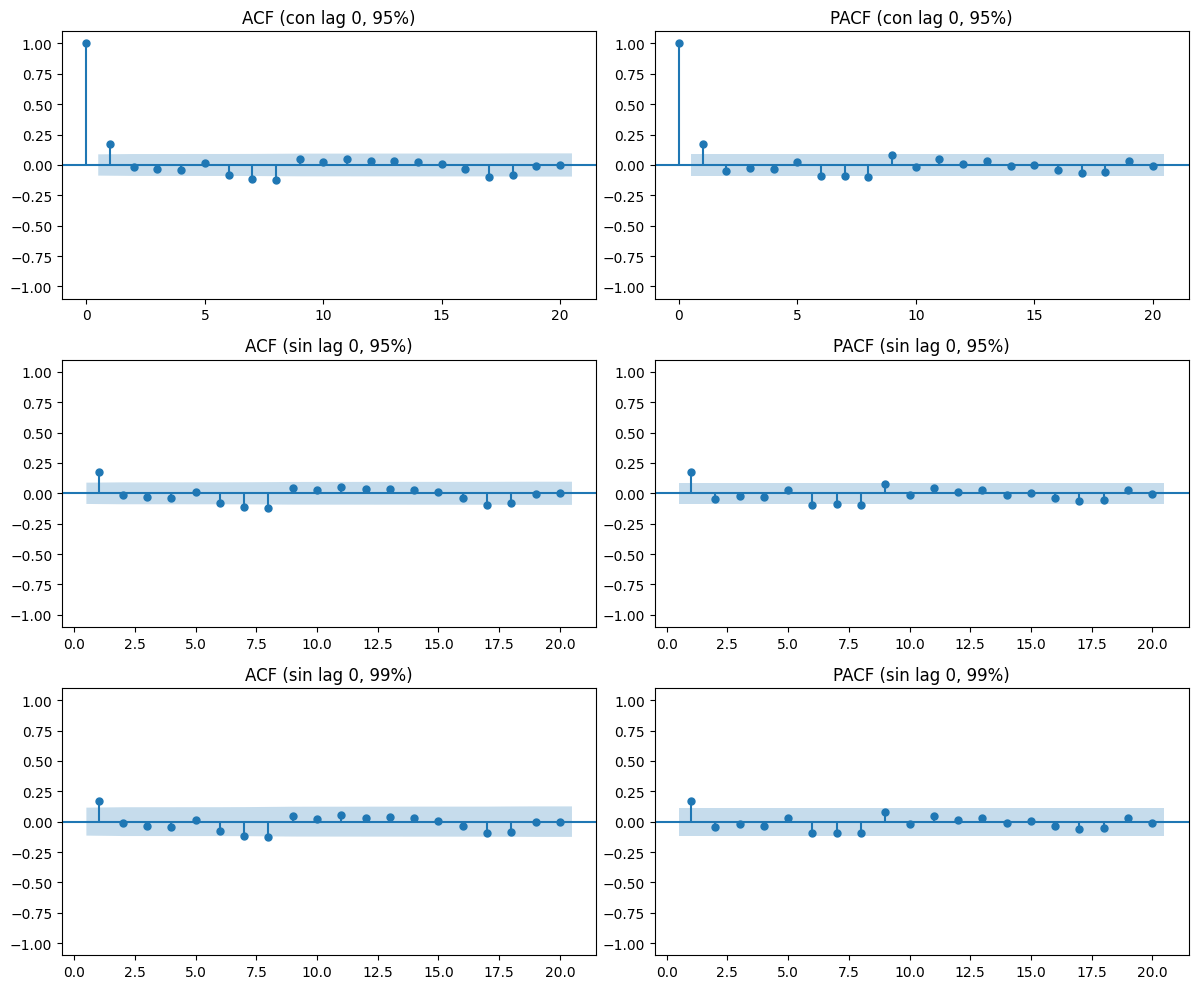

In [8]:
fig, axes = plt.subplots(3, 2, figsize=(12, 10))

plot_acf(y, lags=20, zero=True, alpha=0.05, ax=axes[0, 0])
axes[0, 0].set_ylim(-1.1, 1.1)
axes[0, 0].set_title("ACF (con lag 0, 95%)")

plot_pacf(y, lags=20, zero=True, alpha=0.05, method="ywm", ax=axes[0, 1])
axes[0, 1].set_ylim(-1.1, 1.1)
axes[0, 1].set_title("PACF (con lag 0, 95%)")

plot_acf(y, lags=20, zero=False, alpha=0.05, ax=axes[1, 0])
axes[1, 0].set_ylim(-1.1, 1.1)
axes[1, 0].set_title("ACF (sin lag 0, 95%)")

plot_pacf(y, lags=20, zero=False, alpha=0.05, method="ywm", ax=axes[1, 1])
axes[1, 1].set_ylim(-1.1, 1.1)
axes[1, 1].set_title("PACF (sin lag 0, 95%)")

plot_acf(y, lags=20, zero=False, alpha=0.01, ax=axes[2, 0])
axes[2, 0].set_ylim(-1.1, 1.1)
axes[2, 0].set_title("ACF (sin lag 0, 99%)")

plot_pacf(y, lags=20, zero=False, alpha=0.01, method="ywm", ax=axes[2, 1])
axes[2, 1].set_ylim(-1.1, 1.1)
axes[2, 1].set_title("PACF (sin lag 0, 99%)")

plt.tight_layout()
plt.show()

### ARIMA(1,0,1)

In [9]:
m1 = SARIMAX(y, order=(1,0,1), trend="c", enforce_invertibility=False)
r1 = m1.fit(disp=False)
r1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   dlws   No. Observations:                  500
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 669.235
Date:                Fri, 22 Aug 2025   AIC                          -1330.469
Time:                        19:13:30   BIC                          -1313.611
Sample:                    02-29-1980   HQIC                         -1323.854
                         - 09-30-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0009      0.004      0.251      0.802      -0.006       0.008
ar.L1         -0.0381      0.266     -0.143      0.886      -0.559       0.483
ma.L1          0.2178      0.259      0.840      0.401      -0.291       0.726
sigma2         0.0040      0.000     21.164      0.000       0.004       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                59.68
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.42   Skew:                            -0.11
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

$AR(1) + MA(7,8): ARIMA(1,0,8)$

con $ma.L1$ a $ma.L6 = 0$

In [10]:
m2 = SARIMAX(y, order=(1, 0, 8),trend="c", enforce_invertibility=False)

restricciones_ma = {f"ma.L{k}": 0.0 for k in range(1, 7)}

r2 = m2.fit_constrained(restricciones_ma, disp=False)
r2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   dlws   No. Observations:                  500
Model:               SARIMAX(1, 0, 8)   Log Likelihood                 674.282
Date:                Fri, 22 Aug 2025   AIC                          -1338.563
Time:                        19:13:30   BIC                          -1317.490
Sample:                    02-29-1980   HQIC                         -1330.294
                         - 09-30-2021                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept         0.0007      0.002      0.316      0.752      -0.004       0.005
ar.L1             0.1622      0.038      4.322      0.000       0.089       0.236
ma.L1 (fixed)          0        nan        nan        nan         nan         nan
ma.L2 (fixed)          0        nan        nan        nan         nan         nan
ma.L3 (fixed)          0        nan        nan        nan         nan         nan
ma.L4 (fixed)          0        nan        nan        nan         nan         nan
ma.L5 (fixed)          0        nan        nan        nan         nan         nan
ma.L6 (fixed)          0        nan        nan        nan         nan         nan
ma.L7            -0.0845      0.042     -2.027      0.043      -0.166      -0.003
ma.L8            -0.1198      0.040     -2.981      0.003      -0.199      -0.041
sigma2            0.0039      0.000     19.869      0.000       0.004       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                40.76
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               1.48   Skew:                            -0.01
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

con $ma.L2$ a $ma.L6=0$

In [11]:
m3 = SARIMAX(y, order=(1,0,8), trend="c", enforce_invertibility=False)
fix_2_6 = {f"ma.L{k}": 0.0 for k in range(2,7)}
r3 = m3.fit_constrained(fix_2_6, disp=False)
r3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   dlws   No. Observations:                  500
Model:               SARIMAX(1, 0, 8)   Log Likelihood                 675.506
Date:                Fri, 22 Aug 2025   AIC                          -1339.011
Time:                        19:13:31   BIC                          -1313.723
Sample:                    02-29-1980   HQIC                         -1329.088
                         - 09-30-2021                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept         0.0011      0.003      0.324      0.746      -0.005       0.008
ar.L1            -0.2243      0.190     -1.183      0.237      -0.596       0.147
ma.L1             0.3923      0.184      2.137      0.033       0.032       0.752
ma.L2 (fixed)          0        nan        nan        nan         nan         nan
ma.L3 (fixed)          0        nan        nan        nan         nan         nan
ma.L4 (fixed)          0        nan        nan        nan         nan         nan
ma.L5 (fixed)          0        nan        nan        nan         nan         nan
ma.L6 (fixed)          0        nan        nan        nan         nan         nan
ma.L7            -0.0773      0.043     -1.799      0.072      -0.162       0.007
ma.L8            -0.1572      0.040     -3.891      0.000      -0.236      -0.078
sigma2            0.0039      0.000     19.748      0.000       0.004       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                38.36
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               1.48   Skew:                            -0.00
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

$AR(1) + MA(7,8): ARIMA(1,0,8)$

con MA Lags 1 a 6 fijos en 0 e índice simple

In [12]:
y.index = pd.RangeIndex(len(y))

m = SARIMAX(y, order=(1,0,8), trend="c", enforce_invertibility=False)
fix_params = {f"ma.L{k}": 0.0 for k in range(1, 7)}
res = m.fit_constrained(fix_params, disp=False)
residuos = res.resid
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   dlws   No. Observations:                  500
Model:               SARIMAX(1, 0, 8)   Log Likelihood                 674.282
Date:                Fri, 22 Aug 2025   AIC                          -1338.563
Time:                        19:13:31   BIC                          -1317.490
Sample:                             0   HQIC                         -1330.294
                                - 500                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept         0.0007      0.002      0.316      0.752      -0.004       0.005
ar.L1             0.1622      0.038      4.322      0.000       0.089       0.236
ma.L1 (fixed)          0        nan        nan        nan         nan         nan
ma.L2 (fixed)          0        nan        nan        nan         nan         nan
ma.L3 (fixed)          0        nan        nan        nan         nan         nan
ma.L4 (fixed)          0        nan        nan        nan         nan         nan
ma.L5 (fixed)          0        nan        nan        nan         nan         nan
ma.L6 (fixed)          0        nan        nan        nan         nan         nan
ma.L7            -0.0845      0.042     -2.027      0.043      -0.166      -0.003
ma.L8            -0.1198      0.040     -2.981      0.003      -0.199      -0.041
sigma2            0.0039      0.000     19.869      0.000       0.004       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                40.76
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               1.48   Skew:                            -0.01
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Test de Ruido Blanco
con 10 lags

H0: es ruido blanco (por eso, queremos NO rechazar)

In [13]:
lb_test = acorr_ljungbox(residuos, lags=[10], return_df=True)
lb_test

,lb_stat,lb_pvalue
10,6.680718,0.755204


Inversas de raíces

In [14]:
ar_roots = res.arroots
ma_roots = res.maroots

inv_ar_roots = 1 / res.arroots
inv_ma_roots = 1 / res.maroots

print("Inversas AR roots:\n", inv_ar_roots)
if np.all([i < 1 for i in inv_ar_roots]):
    print("Todas las raíces AR estan en el interior del círculo unitario.")
else:
    print("Algunas raíces AR no estan en el circulo unitario.")

print("\n\nInversas MA roots:\n", inv_ma_roots)
if np.all([i < 1 for i in inv_ma_roots]):
    print("Todas las raíces MA estan en el interior del círculo unitario.")
else:
    print("Algunas raíces MA no estan en el circulo unitario.")

Inversas AR roots:
 [0.16224762]
Todas las raíces AR estan en el interior del círculo unitario.


Inversas MA roots:
 [ 0.81170398+0.j          0.54696881+0.5882848j   0.54696881-0.5882848j
 -0.0500803 +0.77540436j -0.0500803 -0.77540436j -0.55076972+0.48466256j
 -0.55076972-0.48466256j -0.70394155-0.j        ]
Todas las raíces MA estan en el interior del círculo unitario.
